# Download Data into local for 1Q

In [1]:
import os
import requests
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import psutil

# Create directory for data if it doesn't exist
output_dir = '/home/rvasappanavara/rvasappanavara/shared/nyc_taxi_data'
os.makedirs(output_dir, exist_ok=True)

# Show system resources
mem = psutil.virtual_memory()
print(f"System Memory: {mem.total / (1024**3):.1f} GB total, {mem.available / (1024**3):.1f} GB available")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count()} logical")
print(f"Disk space used: {psutil.disk_usage('/').free / (1024**3):.1f} GB")

System Memory: 251.5 GB total, 223.5 GB available
CPU Cores: 128 physical, 128 logical
Disk space used: 0.1 GB


In [2]:
def download_file(url, local_filename):
    """
    Download a file from a URL with a progress bar
    """
    try:
        with requests.get(url, stream=True, timeout=300) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            
            with open(local_filename, 'wb') as f, tqdm(
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
                    desc=os.path.basename(local_filename)
                ) as progress_bar:
                
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    progress_bar.update(len(chunk))
        
        return {"status": "success", "path": local_filename, "size": os.path.getsize(local_filename)}
    except Exception as e:
        return {"status": "error", "path": local_filename, "error": str(e)}

In [3]:
def download_taxi_data(year, month, output_dir, base_url="https://d37ci6vzurychx.cloudfront.net/trip-data"):
    """
    Download a specific month of taxi data
    """
    month_str = f"{month:02d}"
    filename = f"yellow_tripdata_{year}-{month_str}.parquet"
    url = f"{base_url}/{filename}"
    local_path = os.path.join(output_dir, filename)
    
    # Skip if file already exists and is not empty
    if os.path.exists(local_path) and os.path.getsize(local_path) > 0:
        print(f"File already exists: {filename}, skipping...")
        return {"status": "skipped", "path": local_path, "size": os.path.getsize(local_path)}
    
    print(f"Downloading {filename}...")
    result = download_file(url, local_path)
    
    if result["status"] == "success":
        print(f"Successfully downloaded {filename} ({result['size'] / (1024*1024):.2f} MB)")
    else:
        print(f"Failed to download {filename}: {result['error']}")
    
    return result

In [4]:
# Define years and months to download
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]  # Adjust as needed
months = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 11, 12]  # Adjust as needed
max_workers = 4  # Number of concurrent downloads

# Download files in parallel
start_time = time.time()
download_tasks = [(year, month) for year in years for month in months]
results = {"successful": 0, "failed": 0, "skipped": 0, "total_size_mb": 0}

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [
        executor.submit(download_taxi_data, year, month, output_dir) 
        for year, month in download_tasks
    ]
    
    for future in tqdm(futures, desc="Overall Progress", unit="file"):
        result = future.result()
        if result["status"] == "success":
            results["successful"] += 1
            results["total_size_mb"] += result["size"] / (1024 * 1024)
        elif result["status"] == "skipped":
            results["skipped"] += 1
            results["total_size_mb"] += result["size"] / (1024 * 1024)
        else:
            results["failed"] += 1


File already exists: yellow_tripdata_2014-02.parquet, skipping...
File already exists: yellow_tripdata_2014-04.parquet, skipping...
File already exists: yellow_tripdata_2014-03.parquet, skipping...
File already exists: yellow_tripdata_2014-01.parquet, skipping...
File already exists: yellow_tripdata_2014-05.parquet, skipping...
File already exists: yellow_tripdata_2014-07.parquet, skipping...
File already exists: yellow_tripdata_2014-08.parquet, skipping...
File already exists: yellow_tripdata_2014-09.parquet, skipping...
File already exists: yellow_tripdata_2014-11.parquet, skipping...
File already exists: yellow_tripdata_2014-10.parquet, skipping...
File already exists: yellow_tripdata_2014-12.parquet, skipping...
File already exists: yellow_tripdata_2015-02.parquet, skipping...
File already exists: yellow_tripdata_2015-01.parquet, skipping...
File already exists: yellow_tripdata_2015-04.parquet, skipping...
File already exists: yellow_tripdata_2015-05.parquet, skipping...
File alrea

Overall Progress: 100%|██████████| 132/132 [00:00<00:00, 749.86file/s]

File already exists: yellow_tripdata_2015-10.parquet, skipping...
File already exists: yellow_tripdata_2015-11.parquet, skipping...
File already exists: yellow_tripdata_2015-12.parquet, skipping...
File already exists: yellow_tripdata_2016-02.parquet, skipping...
File already exists: yellow_tripdata_2015-03.parquet, skipping...
File already exists: yellow_tripdata_2016-04.parquet, skipping...
File already exists: yellow_tripdata_2016-05.parquet, skipping...
File already exists: yellow_tripdata_2016-06.parquet, skipping...
File already exists: yellow_tripdata_2016-07.parquet, skipping...
File already exists: yellow_tripdata_2016-08.parquet, skipping...
File already exists: yellow_tripdata_2014-06.parquet, skipping...
File already exists: yellow_tripdata_2016-09.parquet, skipping...
File already exists: yellow_tripdata_2016-10.parquet, skipping...
File already exists: yellow_tripdata_2016-11.parquet, skipping...
File already exists: yellow_tripdata_2016-12.parquet, skipping...
File alrea

In [5]:
# Print summary
elapsed_time = time.time() - start_time
print("\n" + "="*50)
print("Download Summary:")
print(f"Elapsed time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"Years processed: {years}")
print(f"Months processed: {', '.join([str(m) for m in months])}")
print(f"Files successfully downloaded: {results['successful']}")
print(f"Files skipped (already exist): {results['skipped']}")
print(f"Files failed to download: {results['failed']}")
print(f"Total data size: {results['total_size_mb']:.2f} MB ({results['total_size_mb']/1024:.2f} GB)")
print(f"Data saved to: {os.path.abspath(output_dir)}")
print("="*50)


Download Summary:
Elapsed time: 16.09 seconds (0.27 minutes)
Years processed: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Months processed: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
Files successfully downloaded: 0
Files skipped (already exist): 132
Files failed to download: 0
Total data size: 12501.75 MB (12.21 GB)
Data saved to: /home/rvasappanavara/rvasappanavara/shared/nyc_taxi_data


In [6]:
# Add parallel verification of downloaded files
def verify_file(file_path):
    """
    Verify a downloaded Parquet file and return its metadata
    """
    try:
        if not os.path.exists(file_path):
            return {"status": "error", "path": file_path, "message": "File not found"}
        
        # Get file size in MB
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        
        # Read the metadata without loading the entire file
        df = pd.read_parquet(file_path, engine='pyarrow')
        
        return {
            "status": "success",
            "path": file_path,
            "filename": os.path.basename(file_path),
            "size_mb": size_mb,
            "rows": len(df),
            "columns": len(df.columns),
            "column_names": list(df.columns)[:5]  # First 5 column names
        }
    except Exception as e:
        return {"status": "error", "path": file_path, "error": str(e)}


In [7]:
# Parallel verification of downloaded files
print("\nVerifying downloaded files in parallel:")
verification_tasks = []

for year in years:
    for month in months:
        month_str = f"{month:02d}"
        filename = f"yellow_tripdata_{year}-{month_str}.parquet"
        file_path = os.path.join(output_dir, filename)
        verification_tasks.append(file_path)

verification_results = {"successful": 0, "failed": 0, "total_size_mb": 0}

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(verify_file, file_path) for file_path in verification_tasks]
    
    for future in tqdm(futures, desc="Verification Progress", unit="file"):
        result = future.result()
        if result["status"] == "success":
            verification_results["successful"] += 1
            verification_results["total_size_mb"] += result["size_mb"]
            print(f"{result['filename']}: {result['size_mb']:.2f} MB")
            print(f"  Rows: Sample of {result['rows']}, Columns: {result['columns']}")
            print(f"  First few columns: {', '.join(result['column_names'])}")
        else:
            verification_results["failed"] += 1
            print(f"{os.path.basename(result['path'])}: Verification failed - {result.get('error', 'Unknown error')}")

print("\nVerification Summary:")
print(f"Files successfully verified: {verification_results['successful']}")
print(f"Files failed verification: {verification_results['failed']}")
print(f"Total verified data size: {verification_results['total_size_mb']:.2f} MB ({verification_results['total_size_mb']/1024:.2f} GB)")

# Calculate optimal Spark configuration based on data size
data_size_gb = verification_results['total_size_mb'] / 1024


Verifying downloaded files in parallel:


Verification Progress:   1%|          | 1/132 [00:08<19:35,  8.97s/file]

yellow_tripdata_2014-01.parquet: 164.01 MB
  Rows: Sample of 13782517, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   2%|▏         | 2/132 [00:12<13:02,  6.02s/file]

yellow_tripdata_2014-02.parquet: 154.69 MB
  Rows: Sample of 13063794, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2014-03.parquet: 183.52 MB
  Rows: Sample of 15428134, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   3%|▎         | 4/132 [00:16<07:06,  3.33s/file]

yellow_tripdata_2014-04.parquet: 174.71 MB
  Rows: Sample of 14618759, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   4%|▍         | 5/132 [00:22<08:38,  4.08s/file]

yellow_tripdata_2014-05.parquet: 178.05 MB
  Rows: Sample of 14774048, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   5%|▍         | 6/132 [00:25<07:55,  3.77s/file]

yellow_tripdata_2014-06.parquet: 165.78 MB
  Rows: Sample of 13813079, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   5%|▌         | 7/132 [00:25<05:50,  2.80s/file]

yellow_tripdata_2014-07.parquet: 157.46 MB
  Rows: Sample of 13104273, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   6%|▌         | 8/132 [00:31<07:40,  3.71s/file]

yellow_tripdata_2014-08.parquet: 165.17 MB
  Rows: Sample of 12698743, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   7%|▋         | 9/132 [00:34<07:22,  3.60s/file]

yellow_tripdata_2014-09.parquet: 175.34 MB
  Rows: Sample of 13424350, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   8%|▊         | 10/132 [00:35<05:33,  2.73s/file]

yellow_tripdata_2014-10.parquet: 186.59 MB
  Rows: Sample of 14317774, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   8%|▊         | 11/132 [00:38<05:45,  2.85s/file]

yellow_tripdata_2014-11.parquet: 172.70 MB
  Rows: Sample of 13309991, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:   9%|▉         | 12/132 [00:44<07:11,  3.59s/file]

yellow_tripdata_2014-12.parquet: 170.71 MB
  Rows: Sample of 13112117, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  10%|▉         | 13/132 [00:47<06:49,  3.44s/file]

yellow_tripdata_2015-01.parquet: 167.20 MB
  Rows: Sample of 12741035, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  11%|█         | 14/132 [00:47<05:03,  2.57s/file]

yellow_tripdata_2015-02.parquet: 163.69 MB
  Rows: Sample of 12442394, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  11%|█▏        | 15/132 [00:50<05:13,  2.68s/file]

yellow_tripdata_2015-03.parquet: 176.77 MB
  Rows: Sample of 13342951, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  12%|█▏        | 16/132 [00:56<06:50,  3.54s/file]

yellow_tripdata_2015-04.parquet: 172.13 MB
  Rows: Sample of 13063758, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  13%|█▎        | 17/132 [00:59<06:23,  3.34s/file]

yellow_tripdata_2015-05.parquet: 174.03 MB
  Rows: Sample of 13157677, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  14%|█▎        | 18/132 [00:59<04:47,  2.52s/file]

yellow_tripdata_2015-06.parquet: 163.80 MB
  Rows: Sample of 12324936, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  14%|█▍        | 19/132 [01:02<04:50,  2.57s/file]

yellow_tripdata_2015-07.parquet: 153.25 MB
  Rows: Sample of 11559666, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  15%|█▌        | 20/132 [01:07<06:03,  3.24s/file]

yellow_tripdata_2015-08.parquet: 147.10 MB
  Rows: Sample of 11123123, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  16%|█▌        | 21/132 [01:09<05:37,  3.04s/file]

yellow_tripdata_2015-09.parquet: 149.16 MB
  Rows: Sample of 11218122, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  17%|█▋        | 22/132 [01:12<05:19,  2.90s/file]

yellow_tripdata_2015-10.parquet: 163.17 MB
  Rows: Sample of 12307333, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  17%|█▋        | 23/132 [01:12<03:58,  2.19s/file]

yellow_tripdata_2015-11.parquet: 150.36 MB
  Rows: Sample of 11305240, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  18%|█▊        | 24/132 [01:15<04:12,  2.34s/file]

yellow_tripdata_2015-12.parquet: 152.50 MB
  Rows: Sample of 11452996, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  19%|█▉        | 25/132 [01:20<05:27,  3.06s/file]

yellow_tripdata_2016-01.parquet: 144.24 MB
  Rows: Sample of 10905067, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  20%|█▉        | 26/132 [01:23<05:12,  2.95s/file]

yellow_tripdata_2016-02.parquet: 150.79 MB
  Rows: Sample of 11375412, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  20%|██        | 27/132 [01:23<03:55,  2.24s/file]

yellow_tripdata_2016-03.parquet: 162.14 MB
  Rows: Sample of 12203824, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  21%|██        | 28/132 [01:26<04:10,  2.41s/file]

yellow_tripdata_2016-04.parquet: 157.88 MB
  Rows: Sample of 11927996, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  22%|██▏       | 29/132 [01:28<04:12,  2.45s/file]

yellow_tripdata_2016-05.parquet: 158.13 MB
  Rows: Sample of 11832049, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  23%|██▎       | 30/132 [01:42<10:04,  5.93s/file]

yellow_tripdata_2016-06.parquet: 149.05 MB
  Rows: Sample of 11131645, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2016-07.parquet: 137.92 MB
  Rows: Sample of 10294080, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2016-08.parquet: 133.40 MB
  Rows: Sample of 9942263, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2016-09.parquet: 135.28 MB
  Rows: Sample of 10116018, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2016-10.parquet: 145.51 MB
  Rows: Sample of 10854626, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  27%|██▋       | 35/132 [01:43<03:08,  1.94s/file]

yellow_tripdata_2016-11.parquet: 134.61 MB
  Rows: Sample of 10102128, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  27%|██▋       | 36/132 [01:45<03:11,  2.00s/file]

yellow_tripdata_2016-12.parquet: 139.20 MB
  Rows: Sample of 10446697, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  28%|██▊       | 37/132 [01:49<03:48,  2.40s/file]

yellow_tripdata_2017-01.parquet: 128.58 MB
  Rows: Sample of 9710820, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  29%|██▉       | 38/132 [01:52<03:44,  2.39s/file]

yellow_tripdata_2017-02.parquet: 121.73 MB
  Rows: Sample of 9169775, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  30%|██▉       | 39/132 [01:52<03:02,  1.96s/file]

yellow_tripdata_2017-03.parquet: 137.88 MB
  Rows: Sample of 10295441, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  30%|███       | 40/132 [01:55<03:11,  2.08s/file]

yellow_tripdata_2017-04.parquet: 134.80 MB
  Rows: Sample of 10047135, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  31%|███       | 41/132 [01:58<03:49,  2.53s/file]

yellow_tripdata_2017-05.parquet: 135.78 MB
  Rows: Sample of 10102127, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  32%|███▏      | 42/132 [02:00<03:33,  2.37s/file]

yellow_tripdata_2017-06.parquet: 129.21 MB
  Rows: Sample of 9656993, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  33%|███▎      | 43/132 [02:01<02:41,  1.81s/file]

yellow_tripdata_2017-07.parquet: 115.24 MB
  Rows: Sample of 8588486, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  33%|███▎      | 44/132 [02:03<02:42,  1.85s/file]

yellow_tripdata_2017-08.parquet: 113.13 MB
  Rows: Sample of 8422153, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  34%|███▍      | 45/132 [02:07<03:36,  2.49s/file]

yellow_tripdata_2017-09.parquet: 121.02 MB
  Rows: Sample of 8945421, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  35%|███▍      | 46/132 [02:09<03:29,  2.44s/file]

yellow_tripdata_2017-10.parquet: 130.41 MB
  Rows: Sample of 9768672, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  36%|███▌      | 47/132 [02:10<02:37,  1.86s/file]

yellow_tripdata_2017-11.parquet: 124.99 MB
  Rows: Sample of 9284803, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  36%|███▋      | 48/132 [02:12<02:42,  1.94s/file]

yellow_tripdata_2017-12.parquet: 128.04 MB
  Rows: Sample of 9508501, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  37%|███▋      | 49/132 [02:15<03:22,  2.43s/file]

yellow_tripdata_2018-01.parquet: 117.94 MB
  Rows: Sample of 8760687, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  38%|███▊      | 50/132 [02:16<02:29,  1.83s/file]

yellow_tripdata_2018-02.parquet: 113.92 MB
  Rows: Sample of 8492819, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  39%|███▊      | 51/132 [02:18<02:36,  1.93s/file]

yellow_tripdata_2018-03.parquet: 127.37 MB
  Rows: Sample of 9431289, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  39%|███▉      | 52/132 [02:22<03:20,  2.51s/file]

yellow_tripdata_2018-04.parquet: 125.51 MB
  Rows: Sample of 9306216, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  40%|████      | 53/132 [02:24<03:15,  2.47s/file]

yellow_tripdata_2018-05.parquet: 124.79 MB
  Rows: Sample of 9224788, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2018-06.parquet: 118.44 MB
  Rows: Sample of 8714667, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  42%|████▏     | 55/132 [02:26<02:16,  1.78s/file]

yellow_tripdata_2018-07.parquet: 107.04 MB
  Rows: Sample of 7851143, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  42%|████▏     | 56/132 [02:30<02:48,  2.21s/file]

yellow_tripdata_2018-08.parquet: 106.26 MB
  Rows: Sample of 7855040, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  43%|████▎     | 57/132 [02:31<02:38,  2.11s/file]

yellow_tripdata_2018-09.parquet: 110.15 MB
  Rows: Sample of 8049094, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  44%|████▍     | 58/132 [02:32<02:01,  1.65s/file]

yellow_tripdata_2018-10.parquet: 121.02 MB
  Rows: Sample of 8834520, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  45%|████▍     | 59/132 [02:34<02:04,  1.70s/file]

yellow_tripdata_2018-11.parquet: 111.74 MB
  Rows: Sample of 8155449, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  45%|████▌     | 60/132 [02:37<02:34,  2.15s/file]

yellow_tripdata_2018-12.parquet: 112.39 MB
  Rows: Sample of 8195675, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  46%|████▌     | 61/132 [02:39<02:29,  2.11s/file]

yellow_tripdata_2019-01.parquet: 105.32 MB
  Rows: Sample of 7696617, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  47%|████▋     | 62/132 [02:39<01:50,  1.58s/file]

yellow_tripdata_2019-02.parquet: 98.57 MB
  Rows: Sample of 7049370, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  48%|████▊     | 63/132 [02:41<01:54,  1.67s/file]

yellow_tripdata_2019-03.parquet: 110.64 MB
  Rows: Sample of 7866620, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  48%|████▊     | 64/132 [02:44<02:23,  2.11s/file]

yellow_tripdata_2019-04.parquet: 105.04 MB
  Rows: Sample of 7475949, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  49%|████▉     | 65/132 [02:46<02:10,  1.95s/file]

yellow_tripdata_2019-05.parquet: 106.31 MB
  Rows: Sample of 7598445, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  50%|█████     | 66/132 [02:46<01:35,  1.45s/file]

yellow_tripdata_2019-06.parquet: 98.14 MB
  Rows: Sample of 6971560, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  51%|█████     | 67/132 [02:47<01:32,  1.42s/file]

yellow_tripdata_2019-07.parquet: 89.53 MB
  Rows: Sample of 6310419, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  52%|█████▏    | 68/132 [02:50<02:00,  1.88s/file]

yellow_tripdata_2019-08.parquet: 85.83 MB
  Rows: Sample of 6073357, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  52%|█████▏    | 69/132 [02:52<01:53,  1.80s/file]

yellow_tripdata_2019-09.parquet: 92.61 MB
  Rows: Sample of 6567788, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  53%|█████▎    | 70/132 [02:52<01:24,  1.36s/file]

yellow_tripdata_2019-10.parquet: 101.37 MB
  Rows: Sample of 7213891, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  54%|█████▍    | 71/132 [02:55<01:51,  1.83s/file]

yellow_tripdata_2019-11.parquet: 96.20 MB
  Rows: Sample of 6878111, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  55%|█████▍    | 72/132 [02:57<01:42,  1.72s/file]

yellow_tripdata_2019-12.parquet: 96.36 MB
  Rows: Sample of 6896317, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  55%|█████▌    | 73/132 [02:57<01:15,  1.28s/file]

yellow_tripdata_2020-01.parquet: 89.23 MB
  Rows: Sample of 6405008, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  57%|█████▋    | 75/132 [02:58<00:49,  1.16file/s]

yellow_tripdata_2020-02.parquet: 87.87 MB
  Rows: Sample of 6299367, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2020-03.parquet: 42.38 MB
  Rows: Sample of 3007687, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  58%|█████▊    | 77/132 [02:58<00:27,  2.02file/s]

yellow_tripdata_2020-04.parquet: 4.24 MB
  Rows: Sample of 238073, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2020-05.parquet: 5.94 MB
  Rows: Sample of 348415, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  59%|█████▉    | 78/132 [02:59<00:24,  2.19file/s]

yellow_tripdata_2020-06.parquet: 9.07 MB
  Rows: Sample of 549797, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  60%|█████▉    | 79/132 [02:59<00:21,  2.42file/s]

yellow_tripdata_2020-07.parquet: 12.77 MB
  Rows: Sample of 800412, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2020-08.parquet: 15.83 MB
  Rows: Sample of 1007286, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  61%|██████▏   | 81/132 [03:00<00:19,  2.57file/s]

yellow_tripdata_2020-09.parquet: 20.39 MB
  Rows: Sample of 1341017, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  62%|██████▏   | 82/132 [03:00<00:19,  2.55file/s]

yellow_tripdata_2020-10.parquet: 25.09 MB
  Rows: Sample of 1681132, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2020-11.parquet: 22.49 MB
  Rows: Sample of 1509000, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  64%|██████▎   | 84/132 [03:00<00:16,  2.87file/s]

yellow_tripdata_2020-12.parquet: 21.95 MB
  Rows: Sample of 1461898, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  64%|██████▍   | 85/132 [03:01<00:16,  2.77file/s]

yellow_tripdata_2021-01.parquet: 20.68 MB
  Rows: Sample of 1369769, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2021-02.parquet: 20.77 MB
  Rows: Sample of 1371709, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  66%|██████▌   | 87/132 [03:01<00:14,  3.07file/s]

yellow_tripdata_2021-03.parquet: 28.62 MB
  Rows: Sample of 1925152, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  67%|██████▋   | 88/132 [03:03<00:21,  2.00file/s]

yellow_tripdata_2021-04.parquet: 32.44 MB
  Rows: Sample of 2171187, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  68%|██████▊   | 90/132 [03:03<00:18,  2.27file/s]

yellow_tripdata_2021-05.parquet: 36.95 MB
  Rows: Sample of 2507109, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2021-06.parquet: 42.03 MB
  Rows: Sample of 2834264, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  69%|██████▉   | 91/132 [03:04<00:20,  2.02file/s]

yellow_tripdata_2021-07.parquet: 41.67 MB
  Rows: Sample of 2821746, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  70%|███████   | 93/132 [03:06<00:27,  1.41file/s]

yellow_tripdata_2021-08.parquet: 41.41 MB
  Rows: Sample of 2788757, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2021-09.parquet: 43.99 MB
  Rows: Sample of 2963793, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  71%|███████   | 94/132 [03:06<00:20,  1.84file/s]

yellow_tripdata_2021-10.parquet: 50.82 MB
  Rows: Sample of 3463504, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  72%|███████▏  | 95/132 [03:07<00:21,  1.71file/s]

yellow_tripdata_2021-11.parquet: 50.64 MB
  Rows: Sample of 3472949, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  73%|███████▎  | 96/132 [03:08<00:27,  1.31file/s]

yellow_tripdata_2021-12.parquet: 47.34 MB
  Rows: Sample of 3214369, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  73%|███████▎  | 97/132 [03:09<00:27,  1.25file/s]

yellow_tripdata_2022-01.parquet: 36.37 MB
  Rows: Sample of 2463931, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2022-02.parquet: 43.50 MB
  Rows: Sample of 2979431, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  75%|███████▌  | 99/132 [03:10<00:20,  1.60file/s]

yellow_tripdata_2022-03.parquet: 53.10 MB
  Rows: Sample of 3627882, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  76%|███████▌  | 100/132 [03:12<00:28,  1.14file/s]

yellow_tripdata_2022-04.parquet: 52.66 MB
  Rows: Sample of 3599920, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  77%|███████▋  | 102/132 [03:12<00:19,  1.53file/s]

yellow_tripdata_2022-05.parquet: 52.99 MB
  Rows: Sample of 3588295, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2022-06.parquet: 52.80 MB
  Rows: Sample of 3558124, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  78%|███████▊  | 103/132 [03:13<00:19,  1.47file/s]

yellow_tripdata_2022-07.parquet: 47.08 MB
  Rows: Sample of 3174394, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  79%|███████▉  | 104/132 [03:15<00:25,  1.08file/s]

yellow_tripdata_2022-08.parquet: 47.41 MB
  Rows: Sample of 3152677, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  80%|███████▉  | 105/132 [03:16<00:23,  1.14file/s]

yellow_tripdata_2022-09.parquet: 47.32 MB
  Rows: Sample of 3183767, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  80%|████████  | 106/132 [03:16<00:17,  1.45file/s]

yellow_tripdata_2022-10.parquet: 54.42 MB
  Rows: Sample of 3675411, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  81%|████████  | 107/132 [03:17<00:22,  1.10file/s]

yellow_tripdata_2022-11.parquet: 47.79 MB
  Rows: Sample of 3252717, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  83%|████████▎ | 109/132 [03:18<00:13,  1.74file/s]

yellow_tripdata_2022-12.parquet: 51.16 MB
  Rows: Sample of 3399549, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2023-01.parquet: 45.46 MB
  Rows: Sample of 3066766, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  83%|████████▎ | 110/132 [03:18<00:11,  1.85file/s]

yellow_tripdata_2023-02.parquet: 45.54 MB
  Rows: Sample of 2913955, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  84%|████████▍ | 111/132 [03:19<00:13,  1.52file/s]

yellow_tripdata_2023-03.parquet: 53.53 MB
  Rows: Sample of 3403766, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  86%|████████▌ | 113/132 [03:20<00:09,  2.05file/s]

yellow_tripdata_2023-04.parquet: 51.71 MB
  Rows: Sample of 3288250, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2023-05.parquet: 55.94 MB
  Rows: Sample of 3513649, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  86%|████████▋ | 114/132 [03:20<00:08,  2.14file/s]

yellow_tripdata_2023-06.parquet: 52.45 MB
  Rows: Sample of 3307234, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  87%|████████▋ | 115/132 [03:21<00:08,  2.02file/s]

yellow_tripdata_2023-07.parquet: 46.12 MB
  Rows: Sample of 2907108, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  89%|████████▊ | 117/132 [03:22<00:06,  2.15file/s]

yellow_tripdata_2023-08.parquet: 45.92 MB
  Rows: Sample of 2824209, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2023-09.parquet: 45.68 MB
  Rows: Sample of 2846722, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  89%|████████▉ | 118/132 [03:22<00:05,  2.40file/s]

yellow_tripdata_2023-10.parquet: 56.28 MB
  Rows: Sample of 3522285, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  90%|█████████ | 119/132 [03:23<00:05,  2.23file/s]

yellow_tripdata_2023-11.parquet: 53.50 MB
  Rows: Sample of 3339715, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  92%|█████████▏| 121/132 [03:24<00:04,  2.25file/s]

yellow_tripdata_2023-12.parquet: 54.17 MB
  Rows: Sample of 3376567, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2024-01.parquet: 47.65 MB
  Rows: Sample of 2964624, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  92%|█████████▏| 122/132 [03:24<00:03,  2.90file/s]

yellow_tripdata_2024-02.parquet: 48.02 MB
  Rows: Sample of 3007526, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  93%|█████████▎| 123/132 [03:25<00:04,  2.06file/s]

yellow_tripdata_2024-03.parquet: 57.30 MB
  Rows: Sample of 3582628, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  94%|█████████▍| 124/132 [03:26<00:04,  1.60file/s]

yellow_tripdata_2024-04.parquet: 56.39 MB
  Rows: Sample of 3514289, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  95%|█████████▍| 125/132 [03:26<00:03,  1.83file/s]

yellow_tripdata_2024-05.parquet: 59.66 MB
  Rows: Sample of 3723833, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance
yellow_tripdata_2024-06.parquet: 57.09 MB
  Rows: Sample of 3539193, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  96%|█████████▌| 127/132 [03:27<00:02,  2.28file/s]

yellow_tripdata_2024-07.parquet: 49.88 MB
  Rows: Sample of 3076903, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  97%|█████████▋| 128/132 [03:28<00:02,  1.70file/s]

yellow_tripdata_2024-08.parquet: 48.70 MB
  Rows: Sample of 2979183, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  98%|█████████▊| 129/132 [03:28<00:01,  2.05file/s]

yellow_tripdata_2024-09.parquet: 58.34 MB
  Rows: Sample of 3633030, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  98%|█████████▊| 130/132 [03:28<00:00,  2.33file/s]

yellow_tripdata_2024-10.parquet: 61.37 MB
  Rows: Sample of 3833771, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress:  99%|█████████▉| 131/132 [03:28<00:00,  2.50file/s]

yellow_tripdata_2024-11.parquet: 57.85 MB
  Rows: Sample of 3646369, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance


Verification Progress: 100%|██████████| 132/132 [03:29<00:00,  1.58s/file]

yellow_tripdata_2024-12.parquet: 58.67 MB
  Rows: Sample of 3668371, Columns: 19
  First few columns: VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance

Verification Summary:
Files successfully verified: 132
Files failed verification: 0
Total verified data size: 12501.75 MB (12.21 GB)


# Set Up Spark Environment

In [8]:
# Import necessary Spark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Get system memory
import psutil
mem = psutil.virtual_memory()
total_mem_gb = mem.total / (1024**3)
cores = psutil.cpu_count()

# Data size from previous cell (if not available, set a default)
try:
    print(f"Configuring for {data_size_gb:.2f} GB of data")
except NameError:
    # Default estimate if data_size_gb is not defined from previous cell
    data_size_gb = 10
    print(f"Using default data size estimate of {data_size_gb} GB")

# Calculate optimal memory allocation
reserved_mem_gb = max(4, total_mem_gb * 0.2)  # Reserve memory for OS
available_mem_gb = total_mem_gb - reserved_mem_gb
driver_mem_gb = min(max(4, available_mem_gb * 0.25), 16)  # Max 16GB for driver
executor_mem_gb = max(4, available_mem_gb * 0.6)  # 60% of available memory

# Calculate optimal parallelism
shuffle_partitions = min(max(200, int(data_size_gb * 10)), 1000)

Configuring for 12.21 GB of data


In [9]:
# Create Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis") \
    .config("spark.driver.memory", f"{int(driver_mem_gb)}g") \
    .config("spark.executor.memory", f"{int(executor_mem_gb)}g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.shuffle.partitions", shuffle_partitions) \
    .config("spark.default.parallelism", cores * 2) \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.sql.files.maxPartitionBytes", 128 * 1024 * 1024) \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

# Print configuration summary
print("\nSpark Configuration Summary:")
print(f"Driver Memory: {int(driver_mem_gb)}g")
print(f"Executor Memory: {int(executor_mem_gb)}g")
print(f"Shuffle Partitions: {shuffle_partitions}")
print(f"Default Parallelism: {spark.sparkContext.defaultParallelism}")
print(f"Available Cores: {cores}")
print(f"System Memory: {total_mem_gb:.1f} GB")

# Test the connection
print("\nTesting Spark session...")
test_df = spark.range(1000).toDF("id")
count = test_df.count()
print(f"Test successful. Created DataFrame with {count} records.")


Spark Configuration Summary:
Driver Memory: 16g
Executor Memory: 120g
Shuffle Partitions: 200
Default Parallelism: 256
Available Cores: 128
System Memory: 251.5 GB

Testing Spark session...
Test successful. Created DataFrame with 1000 records.


In [15]:
# Import PySpark functions with clear aliasing
from pyspark.sql.functions import (
    hour as hour_func,
    dayofweek as dayofweek_func,
    month as month_func,
    year as year_func,
    to_date as to_date_func,
    when as when_func,
    col as col_func,  # Now col is renamed to col_func
    unix_timestamp as unix_timestamp_func,
    avg as avg_func
)
# Import other required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")
print("Imports completed successfully")

Imports completed successfully


# Loading and Exploring the NYC Taxi Data

In [16]:
# Path to the downloaded data
data_path = "nyc_taxi_data/"  # Adjust this path to where you stored the data
year = 2022
month = 1  # January

# Construct the file path
file_path = f"{data_path}yellow_tripdata_{year}-{month:02d}.parquet"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    print(f"Current working directory: {os.getcwd()}")
    print("Please check the file path and try again.")

# Load the Parquet file into a Spark DataFrame
try:
    taxi_df = spark.read.parquet(file_path)
    print(f"Successfully loaded data with {taxi_df.count()} records and {len(taxi_df.columns)} columns")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    
# Display schema
print("\nDataset Schema:")
taxi_df.printSchema()

# Show a sample of the data
print("\nSample Data:")
taxi_df.show(5)

File found: nyc_taxi_data/yellow_tripdata_2022-01.parquet
Successfully loaded data with 2463931 records and 19 columns

Dataset Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = t

# Understanding the Data Structure

In [17]:
# Path to the downloaded data
data_path = "nyc_taxi_data/"  # Adjust this path to where you stored the data
year = 2022
month = 1  # January

# Construct the file path
file_path = f"{data_path}yellow_tripdata_{year}-{month:02d}.parquet"

# Check if the file exists
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    print(f"Current working directory: {os.getcwd()}")
    print("Please check the file path and try again.")

# Load the Parquet file into a Spark DataFrame
try:
    taxi_df = spark.read.parquet(file_path)
    print(f"Successfully loaded data with {taxi_df.count()} records and {len(taxi_df.columns)} columns")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    
# Display schema
print("\nDataset Schema:")
taxi_df.printSchema()

# Show a sample of the data
print("\nSample Data:")
taxi_df.show(5)

File found: nyc_taxi_data/yellow_tripdata_2022-01.parquet
Successfully loaded data with 2463931 records and 19 columns

Dataset Schema:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = t

# Creating Features for EDA

In [18]:
# Add temporal features
enhanced_df = taxi_df.withColumn("pickup_hour", hour_func("tpep_pickup_datetime")) \
    .withColumn("pickup_day", dayofweek_func("tpep_pickup_datetime")) \
    .withColumn("pickup_month", month_func("tpep_pickup_datetime")) \
    .withColumn("pickup_year", year_func("tpep_pickup_datetime")) \
    .withColumn("pickup_date", to_date_func("tpep_pickup_datetime")) \
    .withColumn("is_weekend", when_func(dayofweek_func("tpep_pickup_datetime").isin([1, 7]), True).otherwise(False)) \
    .withColumn("trip_duration_minutes", 
                (unix_timestamp_func("tpep_dropoff_datetime") - unix_timestamp_func("tpep_pickup_datetime")) / 60) \
    .withColumn("time_of_day", 
               when_func((hour_func("tpep_pickup_datetime") >= 6) & (hour_func("tpep_pickup_datetime") < 12), "Morning")
               .when((hour_func("tpep_pickup_datetime") >= 12) & (hour_func("tpep_pickup_datetime") < 18), "Afternoon")
               .when((hour_func("tpep_pickup_datetime") >= 18) & (hour_func("tpep_pickup_datetime") < 22), "Evening")
               .otherwise("Night")) \
    .withColumn("speed_mph", when_func(col_func("trip_duration_minutes") > 0, 
                                 col_func("trip_distance") / (col_func("trip_duration_minutes") / 60)).otherwise(0)) \
    .withColumn("tip_percentage", when_func(col_func("fare_amount") > 0, 
                                      (col_func("tip_amount") / col_func("fare_amount")) * 100).otherwise(0))

# Clean the data by filtering out extreme values
cleaned_df = enhanced_df.filter(
    (col_func("trip_distance") > 0) & (col_func("trip_distance") < 100) &
    (col_func("fare_amount") > 0) & (col_func("fare_amount") < 1000) &
    (col_func("passenger_count") > 0) & (col_func("passenger_count") < 10) &
    (col_func("trip_duration_minutes") > 0) & (col_func("trip_duration_minutes") < 180) &
    (col_func("speed_mph") < 100)  # Reasonable speed limit
)

# Check data size after cleaning
original_count = taxi_df.count()
cleaned_count = cleaned_df.count()
removed_percentage = ((original_count - cleaned_count) / original_count) * 100

print(f"Original dataset: {original_count} records")
print(f"Cleaned dataset: {cleaned_count} records")
print(f"Removed {original_count - cleaned_count} records ({removed_percentage:.2f}%)")

# Show the enhanced dataset
print("\nEnhanced Dataset Sample:")
cleaned_df.select("tpep_pickup_datetime", "pickup_hour", "time_of_day", "is_weekend", 
                 "trip_distance", "trip_duration_minutes", "speed_mph", 
                 "fare_amount", "tip_amount", "tip_percentage").show(5)

Original dataset: 2463931 records
Cleaned dataset: 2297632 records
Removed 166299 records (6.75%)

Enhanced Dataset Sample:
+--------------------+-----------+-----------+----------+-------------+---------------------+------------------+-----------+----------+------------------+
|tpep_pickup_datetime|pickup_hour|time_of_day|is_weekend|trip_distance|trip_duration_minutes|         speed_mph|fare_amount|tip_amount|    tip_percentage|
+--------------------+-----------+-----------+----------+-------------+---------------------+------------------+-----------+----------+------------------+
| 2022-01-01 00:35:40|          0|      Night|      true|          3.8|   17.816666666666666|12.797006548175863|       14.5|      3.65| 25.17241379310345|
| 2022-01-01 00:33:43|          0|      Night|      true|          2.1|                  8.4|              15.0|        8.0|       4.0|              50.0|
| 2022-01-01 00:53:21|          0|      Night|      true|         0.97|    8.966666666666667|6.490706

# Basic Statistics and Data Quality Insights

In [19]:
# Check data size after cleaning
original_count = taxi_df.count()
enhanced_count = enhanced_df.count()
cleaned_count = cleaned_df.count()

print(f"Original dataset: {original_count} records")
print(f"Enhanced dataset: {enhanced_count} records")
print(f"Cleaned dataset: {cleaned_count} records")
print(f"Removed {original_count - cleaned_count} records ({(original_count - cleaned_count) / original_count * 100:.2f}%)")

# Basic statistics for key numeric columns
numeric_columns = ["trip_distance", "fare_amount", "tip_amount", "trip_duration_minutes", 
                   "speed_mph", "tip_percentage", "passenger_count"]

print("\nBasic Statistics for Key Metrics:")
cleaned_df.select(numeric_columns).summary("count", "min", "25%", "mean", "50%", "75%", "max").show()

Original dataset: 2463931 records
Enhanced dataset: 2463931 records
Cleaned dataset: 2297632 records
Removed 166299 records (6.75%)

Basic Statistics for Key Metrics:
+-------+------------------+------------------+------------------+---------------------+--------------------+------------------+------------------+
|summary|     trip_distance|       fare_amount|        tip_amount|trip_duration_minutes|           speed_mph|    tip_percentage|   passenger_count|
+-------+------------------+------------------+------------------+---------------------+--------------------+------------------+------------------+
|  count|           2297632|           2297632|           2297632|              2297632|             2297632|           2297632|           2297632|
|    min|              0.01|              0.01|               0.0| 0.016666666666666666|0.003899057727715802|               0.0|               1.0|
|    25%|              1.07|               6.5|               1.0|    6.383333333333334|   8.

# Register a Temporary View for SQL-Based Analysis

In [20]:
# Register the dataframe as a temporary view for SQL analysis
cleaned_df.createOrReplaceTempView("nyc_taxi")

# Basic count by time of day
print("\nTrip Distribution by Time of Day:")
spark.sql("""
    SELECT 
        time_of_day,
        COUNT(*) as trip_count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc_taxi), 2) as percentage
    FROM 
        nyc_taxi
    GROUP BY 
        time_of_day
    ORDER BY 
        CASE 
            WHEN time_of_day = 'Morning' THEN 1
            WHEN time_of_day = 'Afternoon' THEN 2
            WHEN time_of_day = 'Evening' THEN 3
            WHEN time_of_day = 'Night' THEN 4
        END
""").show()


Trip Distribution by Time of Day:
+-----------+----------+----------+
|time_of_day|trip_count|percentage|
+-----------+----------+----------+
|    Morning|    529236|     23.03|
|  Afternoon|    912874|     39.73|
|    Evening|    522296|     22.73|
|      Night|    333226|     14.50|
+-----------+----------+----------+



# Analyze Trip Patterns by Hour, Day, and Weekend vs. Weekday

In [21]:
# Hourly patterns
print("\nHourly Trip Statistics:")
spark.sql("""
    SELECT 
        pickup_hour,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration,
        ROUND(AVG(tip_percentage), 2) as avg_tip_percentage
    FROM 
        nyc_taxi
    GROUP BY 
        pickup_hour
    ORDER BY 
        pickup_hour
""").show(24)

# Day of week patterns
print("\nDay of Week Trip Statistics:")
spark.sql("""
    SELECT 
        pickup_day,
        CASE pickup_day
            WHEN 1 THEN 'Sunday'
            WHEN 2 THEN 'Monday'
            WHEN 3 THEN 'Tuesday'
            WHEN 4 THEN 'Wednesday'
            WHEN 5 THEN 'Thursday'
            WHEN 6 THEN 'Friday'
            WHEN 7 THEN 'Saturday'
        END as day_name,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance
    FROM 
        nyc_taxi
    GROUP BY 
        pickup_day
    ORDER BY 
        pickup_day
""").show()

# Weekend vs. weekday comparison
print("\nWeekend vs. Weekday Comparison:")
spark.sql("""
    SELECT 
        CASE WHEN is_weekend = true THEN 'Weekend' ELSE 'Weekday' END as day_type,
        COUNT(*) as trip_count,
        ROUND(AVG(fare_amount), 2) as avg_fare,
        ROUND(AVG(tip_amount), 2) as avg_tip,
        ROUND(AVG(trip_distance), 2) as avg_distance,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration,
        ROUND(AVG(speed_mph), 2) as avg_speed,
        ROUND(AVG(tip_percentage), 2) as avg_tip_percentage
    FROM 
        nyc_taxi
    GROUP BY 
        is_weekend
""").show()


Hourly Trip Statistics:
+-----------+----------+--------+-------+------------+------------+------------------+
|pickup_hour|trip_count|avg_fare|avg_tip|avg_distance|avg_duration|avg_tip_percentage|
+-----------+----------+--------+-------+------------+------------+------------------+
|          0|     55070|   14.11|   2.61|        3.95|       12.19|             21.48|
|          1|     38511|   13.14|   2.46|        3.55|       11.61|              22.1|
|          2|     26338|   12.43|   2.37|        3.28|       11.26|             22.63|
|          3|     17360|   13.23|    2.3|        3.55|        11.7|             21.03|
|          4|     11107|   15.22|   2.39|        4.25|       12.52|             19.13|
|          5|     12719|   18.11|   2.65|        5.38|       13.41|             17.31|
|          6|     32597|   15.13|   2.46|        4.33|       12.96|             19.27|
|          7|     67359|   12.73|   2.29|        3.23|       12.68|             20.45|
|          8|     

# Analyze Fares and Tips

In [22]:
# Analyze tip percentage distribution
print("\nTip Percentage Distribution:")
spark.sql("""
    SELECT 
        CASE 
            WHEN tip_percentage = 0 THEN 'No Tip'
            WHEN tip_percentage <= 10 THEN '1-10%'
            WHEN tip_percentage <= 15 THEN '11-15%'
            WHEN tip_percentage <= 20 THEN '16-20%'
            WHEN tip_percentage <= 25 THEN '21-25%'
            ELSE 'Over 25%'
        END as tip_bracket,
        COUNT(*) as trip_count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM nyc_taxi), 2) as percentage
    FROM 
        nyc_taxi
    GROUP BY 
        CASE 
            WHEN tip_percentage = 0 THEN 'No Tip'
            WHEN tip_percentage <= 10 THEN '1-10%'
            WHEN tip_percentage <= 15 THEN '11-15%'
            WHEN tip_percentage <= 20 THEN '16-20%'
            WHEN tip_percentage <= 25 THEN '21-25%'
            ELSE 'Over 25%'
        END
    ORDER BY 
        CASE tip_bracket
            WHEN 'No Tip' THEN 1
            WHEN '1-10%' THEN 2
            WHEN '11-15%' THEN 3
            WHEN '16-20%' THEN 4
            WHEN '21-25%' THEN 5
            ELSE 6
        END
""").show()

# Analyze correlation between distance and fare
print("\nCorrelation between Trip Distance and Fare Amount:")
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Create vector column for correlation analysis
assembler = VectorAssembler(inputCols=["trip_distance", "fare_amount"], outputCol="features")
vector_df = assembler.transform(cleaned_df)

# Calculate correlation
corr_matrix = Correlation.corr(vector_df, "features").collect()[0][0]
print(f"Pearson correlation coefficient: {corr_matrix[0, 1]}")


Tip Percentage Distribution:
+-----------+----------+----------+
|tip_bracket|trip_count|percentage|
+-----------+----------+----------+
|     No Tip|    545479|     23.74|
|      1-10%|     64465|      2.81|
|     11-15%|    118369|      5.15|
|     16-20%|    148360|      6.46|
|     21-25%|    292198|     12.72|
|   Over 25%|   1128761|     49.13|
+-----------+----------+----------+


Correlation between Trip Distance and Fare Amount:
Pearson correlation coefficient: 0.9513520816567353


In [23]:
# Set up the visualization environment
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Sample data for visualization - Fixed the min() function issue
# In PySpark, min() is used differently than in Python
sample_size = 10000
total_count = cleaned_df.count()
sample_ratio = 0.1 if total_count > 100000 else sample_size / float(total_count)

# Get a sample of the data for visualization
sample_df = cleaned_df.sample(withReplacement=False, fraction=sample_ratio, seed=42).toPandas()
print(f"Sampled {len(sample_df)} records out of {total_count} for visualization")

Sampled 230301 records out of 2297632 for visualization


# Trip Count by Hour

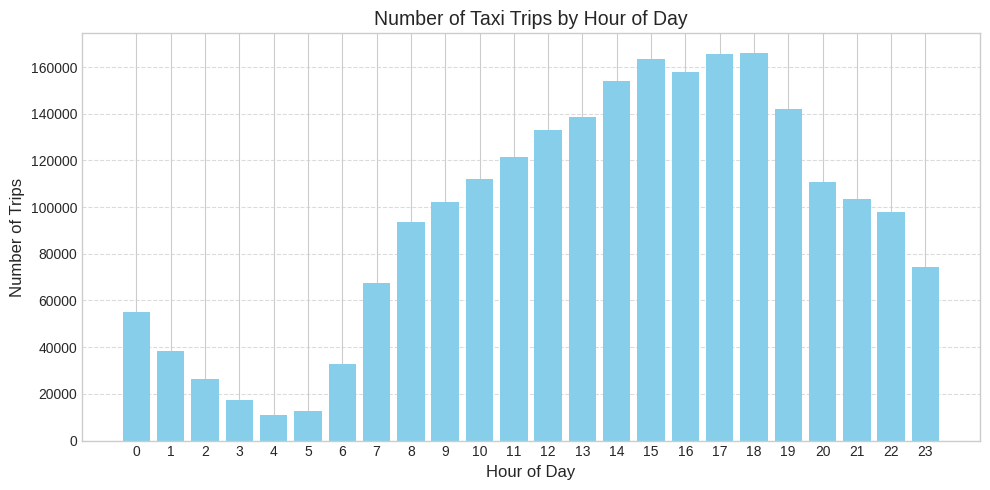

In [24]:
# 1. Trip Count by Hour
hourly_counts = cleaned_df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

plt.figure(figsize=(10, 5))
plt.bar(hourly_counts["pickup_hour"], hourly_counts["count"], color='skyblue')
plt.title("Number of Taxi Trips by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Average Fare by Hour

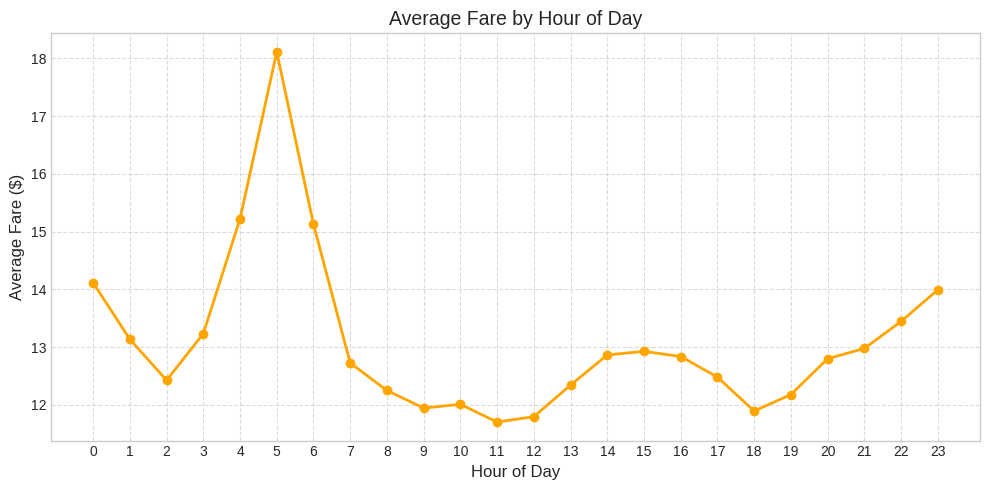

In [25]:
# 2. Average Fare by Hour
hourly_fares = cleaned_df.groupBy("pickup_hour") \
    .agg(F.avg("fare_amount").alias("avg_fare")) \
    .orderBy("pickup_hour") \
    .toPandas()

plt.figure(figsize=(10, 5))
plt.plot(hourly_fares["pickup_hour"], hourly_fares["avg_fare"], 'o-', color='orange', linewidth=2)
plt.title("Average Fare by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Fare ($)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Distance Distribution

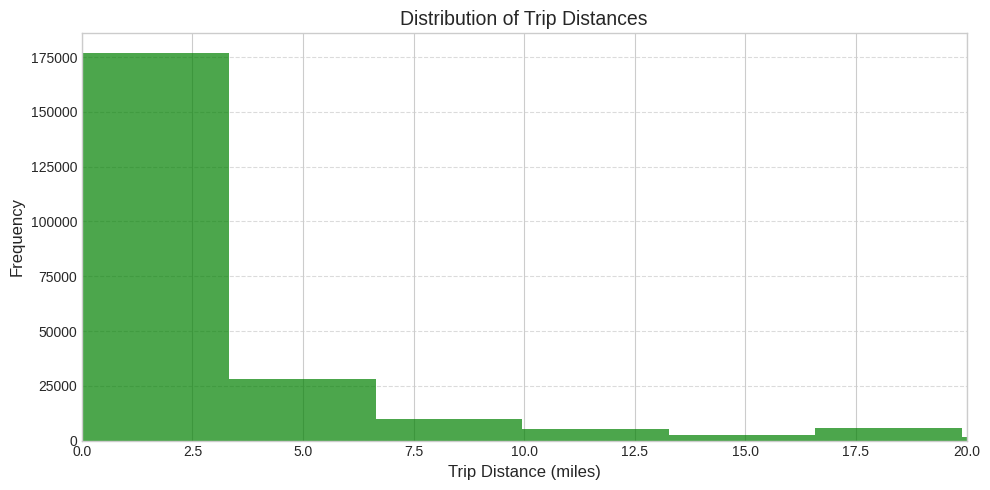

In [26]:
# 3. Trip Distance Distribution
plt.figure(figsize=(10, 5))
plt.hist(sample_df["trip_distance"], bins=30, alpha=0.7, color='green')
plt.title("Distribution of Trip Distances", fontsize=14)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0, 20)  # Focus on most common distances
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Distance vs. Fare Amount (Scatter Plot)

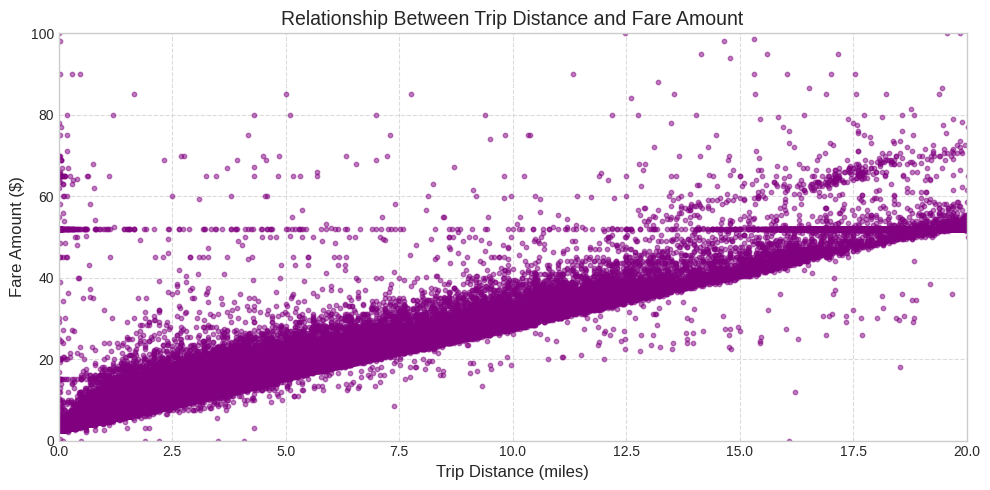

In [27]:
# 4. Trip Distance vs. Fare Amount Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(sample_df["trip_distance"], sample_df["fare_amount"], alpha=0.5, color='purple', s=10)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=14)
plt.xlabel("Trip Distance (miles)", fontsize=12)
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Trip Count vs Tip Percentage

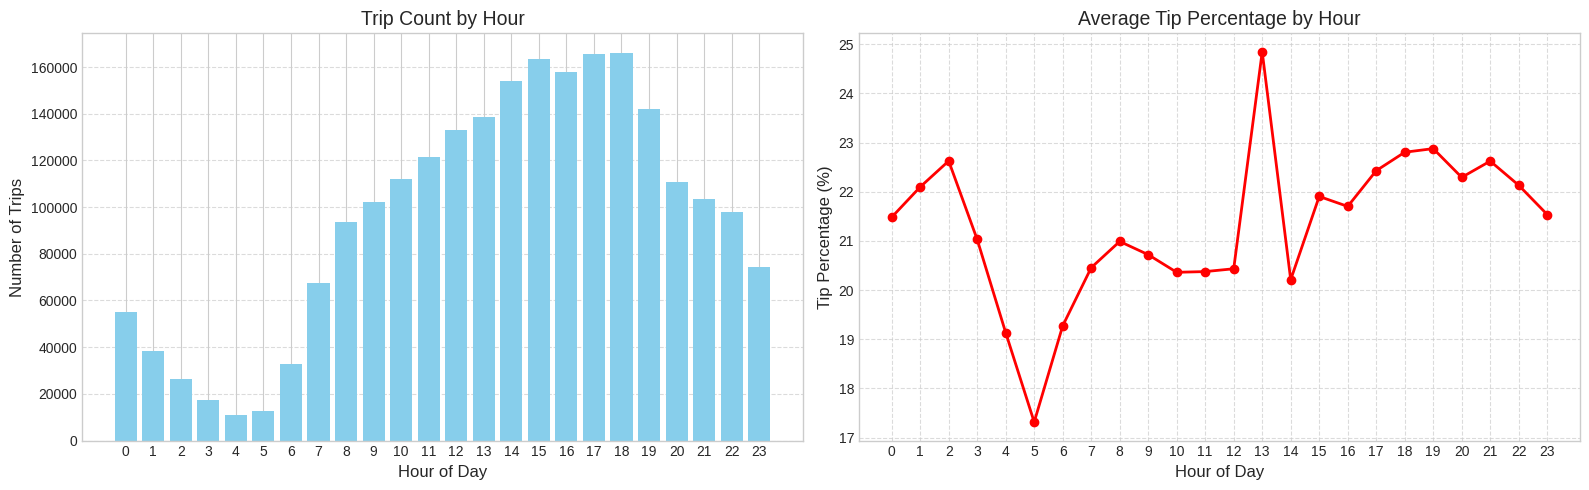

In [29]:
# First, calculate the data needed for the plots
# 1. Trip Count by Hour
hourly_counts = cleaned_df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

# 2. Average Tip Percentage by Hour
hourly_tips = cleaned_df.groupBy("pickup_hour") \
    .agg(F.avg("tip_percentage").alias("avg_tip_pct")) \
    .orderBy("pickup_hour") \
    .toPandas()

# Now create the side-by-side plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot - Trip Count
ax1.bar(hourly_counts["pickup_hour"], hourly_counts["count"], color='skyblue')
ax1.set_title("Trip Count by Hour", fontsize=14)
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Number of Trips", fontsize=12)
ax1.set_xticks(range(0, 24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right plot - Tip Percentage
ax2.plot(hourly_tips["pickup_hour"], hourly_tips["avg_tip_pct"], 'o-', color='red', linewidth=2)
ax2.set_title("Average Tip Percentage by Hour", fontsize=14)
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Tip Percentage (%)", fontsize=12)
ax2.set_xticks(range(0, 24))
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Distribution of Key Metrics

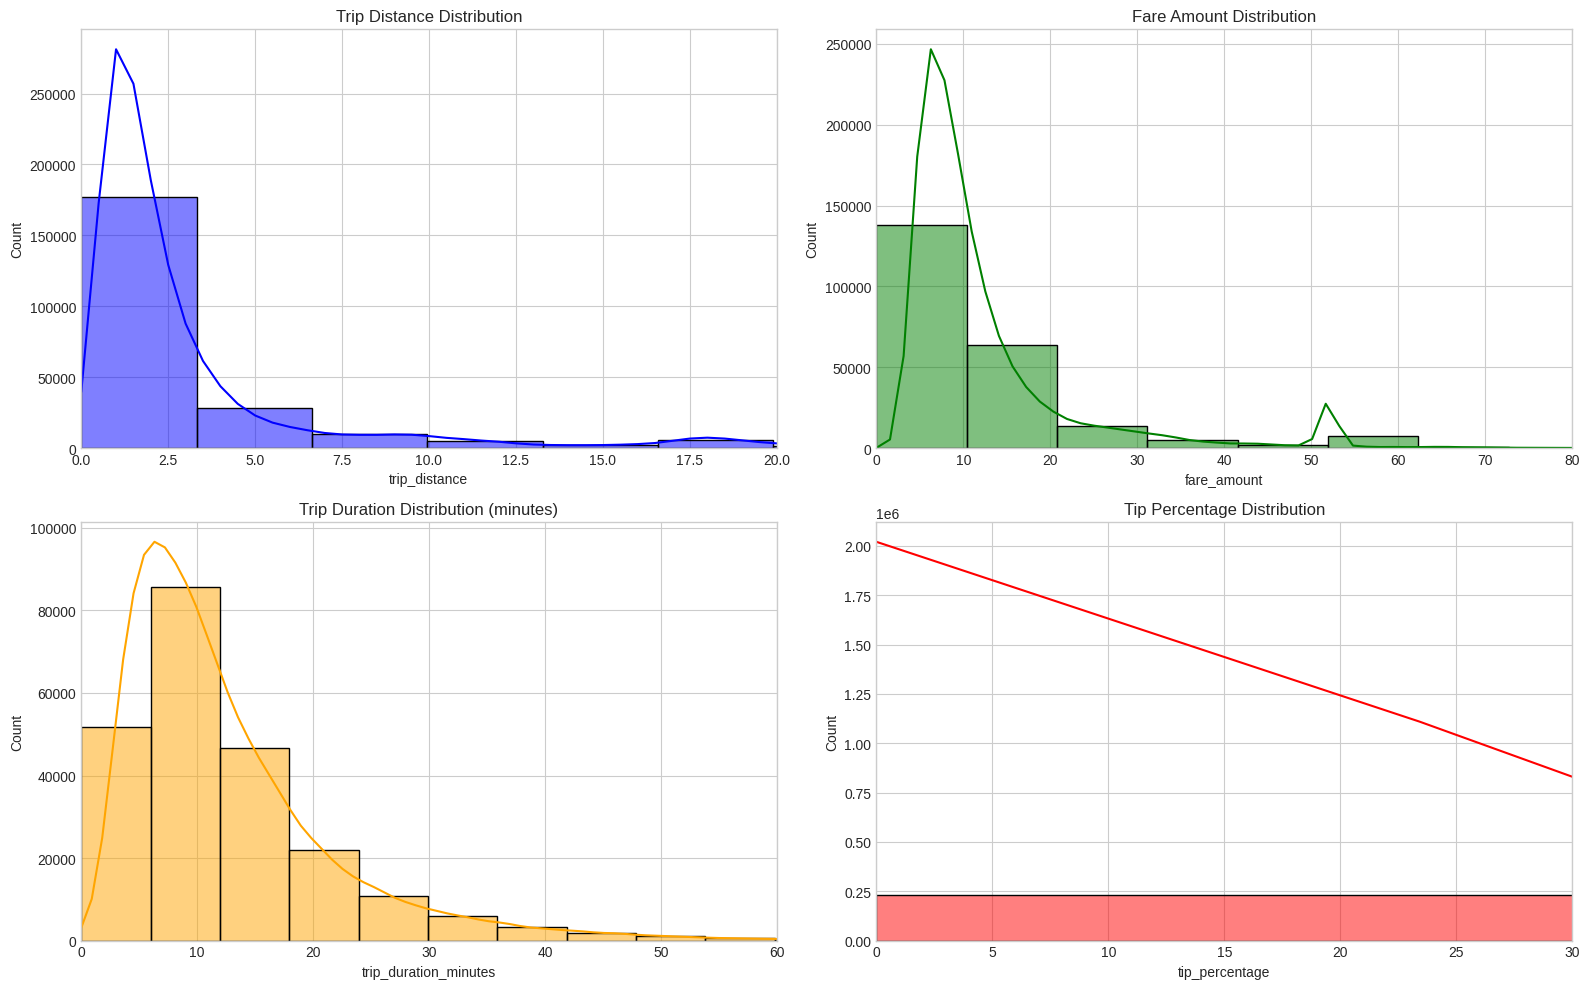

In [30]:
# 7. Multi-panel distribution plots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Trip Distance
sns.histplot(sample_df["trip_distance"], bins=30, kde=True, ax=axs[0, 0], color='blue')
axs[0, 0].set_title('Trip Distance Distribution')
axs[0, 0].set_xlim(0, 20)

# Fare Amount
sns.histplot(sample_df["fare_amount"], bins=30, kde=True, ax=axs[0, 1], color='green')
axs[0, 1].set_title('Fare Amount Distribution')
axs[0, 1].set_xlim(0, 80)

# Trip Duration
sns.histplot(sample_df["trip_duration_minutes"], bins=30, kde=True, ax=axs[1, 0], color='orange')
axs[1, 0].set_title('Trip Duration Distribution (minutes)')
axs[1, 0].set_xlim(0, 60)

# Tip Percentage
sns.histplot(sample_df["tip_percentage"], bins=30, kde=True, ax=axs[1, 1], color='red')
axs[1, 1].set_title('Tip Percentage Distribution')
axs[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

# Weekday vs. Weekend Comparison

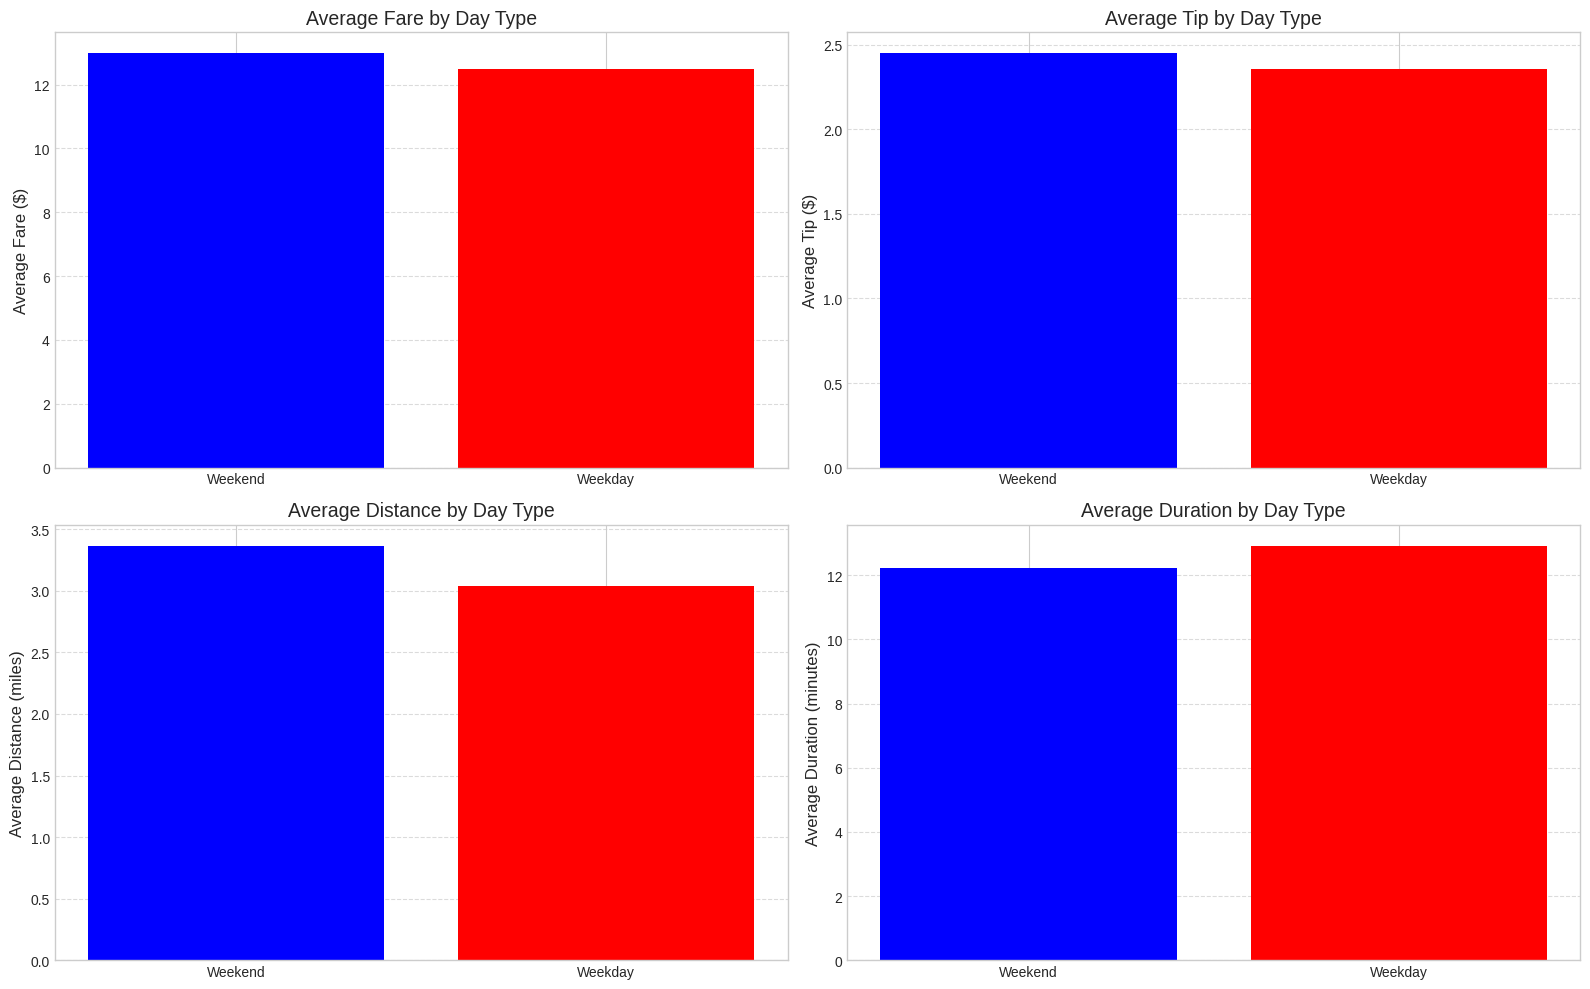

In [31]:
# 8. Weekday vs Weekend comparison
day_type_stats = cleaned_df.groupBy("is_weekend") \
    .agg(
        F.count("*").alias("trip_count"),
        F.avg("fare_amount").alias("avg_fare"),
        F.avg("tip_amount").alias("avg_tip"),
        F.avg("trip_distance").alias("avg_distance"),
        F.avg("trip_duration_minutes").alias("avg_duration")
    ) \
    .toPandas()

# Convert boolean to string for better labels
day_type_stats["day_type"] = day_type_stats["is_weekend"].apply(lambda x: "Weekend" if x else "Weekday")

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Average Fare
axs[0, 0].bar(day_type_stats["day_type"], day_type_stats["avg_fare"], color=['blue', 'red'])
axs[0, 0].set_title('Average Fare by Day Type', fontsize=14)
axs[0, 0].set_ylabel('Average Fare ($)', fontsize=12)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Average Tip
axs[0, 1].bar(day_type_stats["day_type"], day_type_stats["avg_tip"], color=['blue', 'red'])
axs[0, 1].set_title('Average Tip by Day Type', fontsize=14)
axs[0, 1].set_ylabel('Average Tip ($)', fontsize=12)
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Average Distance
axs[1, 0].bar(day_type_stats["day_type"], day_type_stats["avg_distance"], color=['blue', 'red'])
axs[1, 0].set_title('Average Distance by Day Type', fontsize=14)
axs[1, 0].set_ylabel('Average Distance (miles)', fontsize=12)
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Average Duration
axs[1, 1].bar(day_type_stats["day_type"], day_type_stats["avg_duration"], color=['blue', 'red'])
axs[1, 1].set_title('Average Duration by Day Type', fontsize=14)
axs[1, 1].set_ylabel('Average Duration (minutes)', fontsize=12)
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Correlation Matrix Heatmap

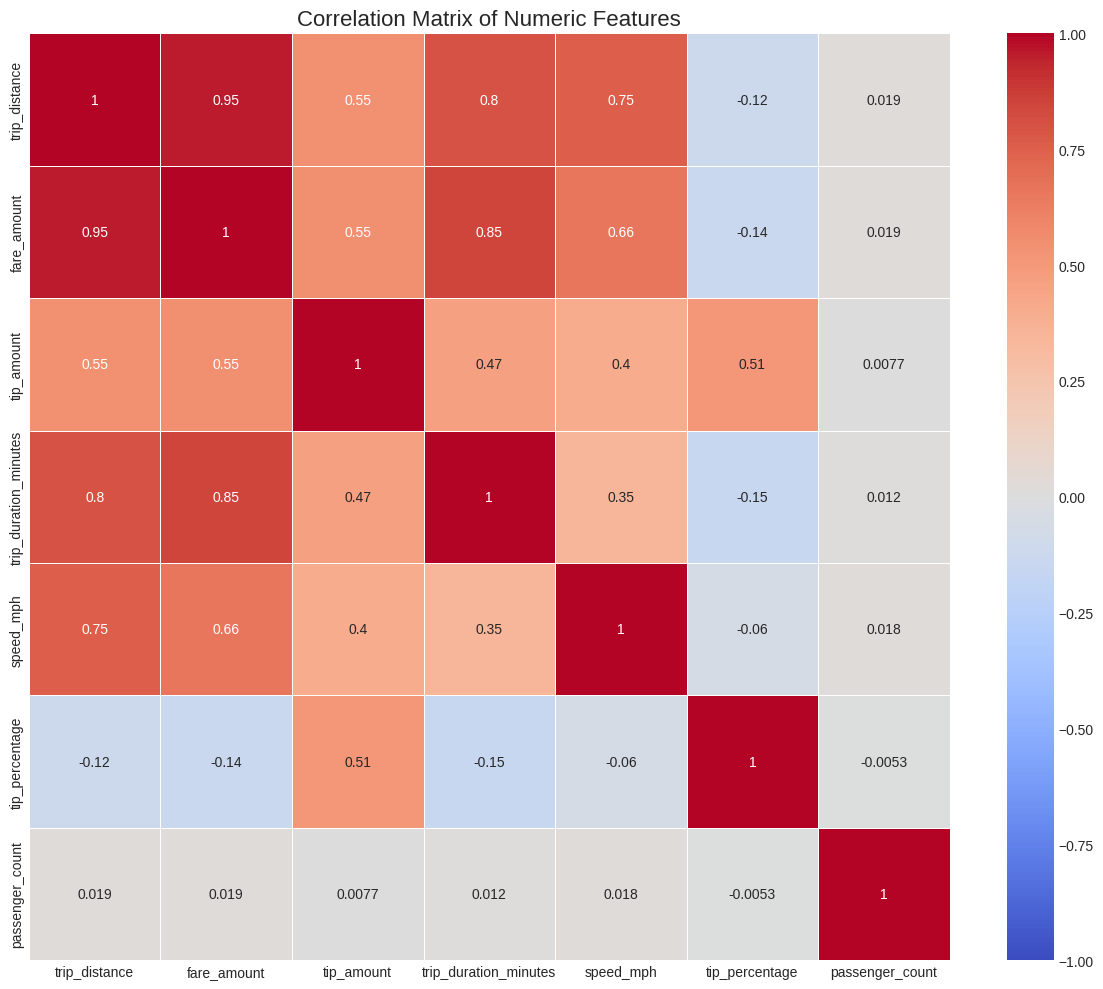

In [32]:
# 9. Correlation matrix heatmap
# Select numeric columns for correlation analysis
numeric_cols = ["trip_distance", "fare_amount", "tip_amount", "trip_duration_minutes", 
               "speed_mph", "tip_percentage", "passenger_count"]

# Calculate correlations using pandas
corr_df = sample_df[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()